# 问题定义

判断易速鲜花会员的是否会流失情况

易速鲜花公司拥有多年的会员记录，以及会员停止续费的情况。

通过逻辑回归和神经网络等机器学习模型，我们可以判断出客户是否离开，这是一个典型的的二元分类问题。


# 数据预处理

In [1]:
import numpy as np # 导入NumPy
import pandas as pd # 导入Pandas
import matplotlib.pyplot as plt # 导入matplotlib.pyplot

In [2]:
df_member = pd.read_csv('易速鲜花会员留存.csv') # 导入数据包
df_member #显示数据

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,会员卡类型,入会月数,会费支付方式,平均月消费,总消费,已停付会费
0,1,女,是,是,否,是,否,是,是,否,年卡,9,手工转账,65.60,593.3,否
1,2,男,否,否,否,否,否,否,否,是,月卡,9,手工转账,59.90,542.4,否
2,3,男,否,否,否,否,是,否,否,否,月卡,4,就餐时付费,73.90,280.85,是
3,4,男,是,否,否,是,是,否,是,是,月卡,13,就餐时付费,98.00,1237.85,是
4,5,女,否,是,否,否,否,是,是,是,月卡,9,花呗付款,69.40,571.45,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,女,否,否,是,否,否,是,否,否,年卡,13,手工转账,55.15,742.9,否
7039,7040,男,否,否,否,是,否,否,否,否,月卡,2,手工转账,50.30,92.75,否
7040,7041,男,是,否,否,否,否,否,否,是,月卡,22,就餐时付费,85.10,1873.7,是
7041,7042,男,是,是,是,否,是,是,否,是,双年卡,67,手工转账,67.85,4627.65,否


## 数据清洗

In [3]:
#把总消费字段转换成数值字段
df_member['总消费'] = pd.to_numeric(df_member['总消费'], errors='coerce')
df_member['总消费'].fillna(0, inplace=True)

## 数据可视化

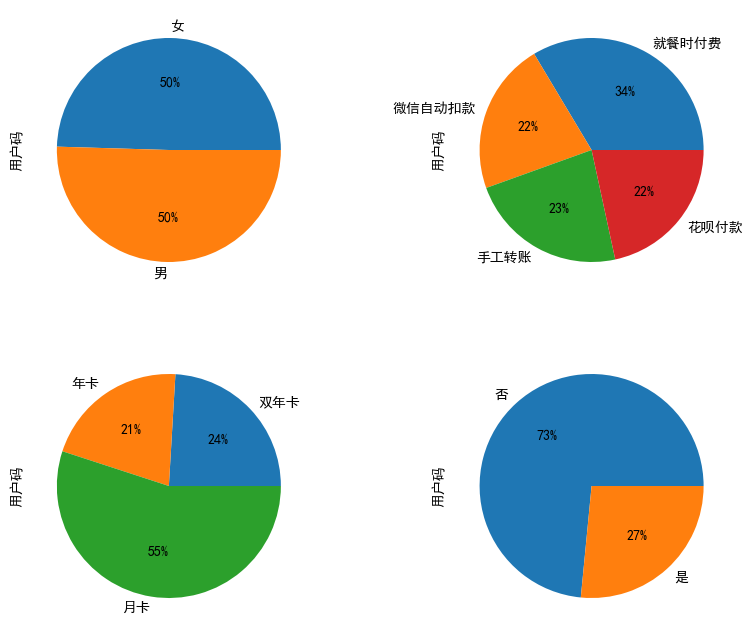

In [4]:
import matplotlib.pyplot as plt #导入绘图工具
plt.rcParams['font.family'] = ['SimHei'] #或者 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,8)) #图片大小
plt.subplot(2, 2, 1) #子图1
ax = df_member.groupby('性别').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图1
plt.subplot(2, 2, 2) #子图2
ax = df_member.groupby('会费支付方式').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图2
plt.subplot(2, 2, 3) #子图3
ax = df_member.groupby('会员卡类型').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图3
plt.subplot(2, 2, 4) #子图4
ax = df_member.groupby('已停付会费').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图4
plt.show() #显示

## 特征工程

In [5]:
df_member['已停付会费'].replace(to_replace='是', value=1, inplace=True) #流失-1
df_member['已停付会费'].replace(to_replace='否',  value=0, inplace=True) #未流失-0

In [6]:
df_member['性别'].replace(to_replace='女', value=0, inplace=True) #女生-0
df_member['性别'].replace(to_replace='男', value=1, inplace=True) #男生-1

In [7]:
# 字段中'Yes' or 'No'转换成为模型可以读取的数值,（布尔型数据，也是数值数据）
binary_features = ['玫瑰套餐', '紫罗兰套餐', '郁金香套餐', '百合套餐', '康乃馨套餐', '胡姬花套餐', 
                   '生日套餐','情人节套餐']
for field in binary_features:
    df_member[field] = df_member[field] == '是'

In [8]:
df_member

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,会员卡类型,入会月数,会费支付方式,平均月消费,总消费,已停付会费
0,1,0,True,True,False,True,False,True,True,False,年卡,9,手工转账,65.60,593.30,0
1,2,1,False,False,False,False,False,False,False,True,月卡,9,手工转账,59.90,542.40,0
2,3,1,False,False,False,False,True,False,False,False,月卡,4,就餐时付费,73.90,280.85,1
3,4,1,True,False,False,True,True,False,True,True,月卡,13,就餐时付费,98.00,1237.85,1
4,5,0,False,True,False,False,False,True,True,True,月卡,9,花呗付款,69.40,571.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,False,False,True,False,False,True,False,False,年卡,13,手工转账,55.15,742.90,0
7039,7040,1,False,False,False,True,False,False,False,False,月卡,2,手工转账,50.30,92.75,0
7040,7041,1,True,False,False,False,False,False,False,True,月卡,22,就餐时付费,85.10,1873.70,1
7041,7042,1,True,True,True,False,True,True,False,True,双年卡,67,手工转账,67.85,4627.65,0


## 数据整理
先做数据整理工作，把每个数据字段都转换为可以处理的字段

In [9]:
# 分类字段哑变量
category_features = ['会员卡类型', '会费支付方式']
df_member = pd.get_dummies(df_member, drop_first=True, columns=category_features)
df_member

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,入会月数,平均月消费,总消费,已停付会费,会员卡类型_年卡,会员卡类型_月卡,会费支付方式_微信自动扣款,会费支付方式_手工转账,会费支付方式_花呗付款
0,1,0,True,True,False,True,False,True,True,False,9,65.60,593.30,0,1,0,0,1,0
1,2,1,False,False,False,False,False,False,False,True,9,59.90,542.40,0,0,1,0,1,0
2,3,1,False,False,False,False,True,False,False,False,4,73.90,280.85,1,0,1,0,0,0
3,4,1,True,False,False,True,True,False,True,True,13,98.00,1237.85,1,0,1,0,0,0
4,5,0,False,True,False,False,False,True,True,True,9,69.40,571.45,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,False,False,True,False,False,True,False,False,13,55.15,742.90,0,1,0,0,1,0
7039,7040,1,False,False,False,True,False,False,False,False,2,50.30,92.75,0,0,1,0,1,0
7040,7041,1,True,False,False,False,False,False,False,True,22,85.10,1873.70,1,0,1,0,0,0
7041,7042,1,True,True,True,False,True,True,False,True,67,67.85,4627.65,0,0,0,0,1,0


## 构建特征集和标签集

In [10]:
X = df_member.drop(['用户码','已停付会费'], axis = 1) # 构建特征集，用户码字段属于无用特征
y = df_member.已停付会费.values # 构建标签集

这段代码创建了特征集 `X` 和标签集 `y`。之前，数据存储在名为 `df_member` 的 DataFrame 中。

1. 使用 `df_member.drop(['用户码','已停付会费'], axis = 1)` 命令，从 DataFrame 中移除 '用户码' 和 '已停付会费' 这两列。DataFrame 对象的 `drop` 方法接受列名（在本例中为 ['用户码','已停付会费']）和“axis”参数值（1 表示沿列）。由于 '用户码' 列对于模型预测毫无帮助，我们选择删除它。然后将结果赋值给变量 `X`，这就是我们的特征集，包含了用于模型训练的所有特征。

2. 从 DataFrame 中提取 '已停付会费' 列。这是目标列，即我们希望预测的输出。通过使用 `df_member.已停付会费.values` 表达式，将 '已停付会费' 列中的值转换成一个 NumPy 数组，并将其赋给变量 `y`。这就是我们的标签集，表示模型需要学习预测的目标值。

现在，我们已经从原始数据中创建了特征集 `X` 和标签集 `y`。接下来的步骤通常包括将数据划分为训练集和测试集、进行预处理（如归一化）并训练神经网络等。

## 拆分数据集

In [11]:
from sklearn.model_selection import train_test_split #导入train_test_split模块
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2) #拆分数据集

# 训练模型

这里我们比较逻辑回归和神经网络两种算法

## 逻辑回归模型

In [12]:
from sklearn.linear_model import LogisticRegression #导入逻辑回归模型
lr = LogisticRegression(max_iter=1000) # lr,就代表是逻辑回归模型

In [13]:
lr.fit(X_train,y_train) # fit,就相当于是梯度下降

LogisticRegression(max_iter=1000)

提示信息中的 "ConvergenceWarning" 表明逻辑回归模型在训练数据上没有收敛。在训练过程中，模型尝试找到一组参数，使得损失函数值达到最小。但在模型迭代次数达到限制之前，模型没有达到收敛。为了解决这个问题，您可以尝试以下解决方案：

1. 增加最大迭代次数（`max_iter`）：给模型更多的时间让参数收敛。在创建逻辑回归模型实例时增加 `max_iter` 参数值，例如：

```python
lr = LogisticRegression(max_iter=1000)
```

2. 标准化/归一化数据：如果数据的某些特征有很大的尺度变化，可能会导致收敛速度较慢。因此，在训练模型之前对特征进行缩放是很重要的。尝试使用 Scikit-learn 的 `StandardScaler`（标准化）或 `MinMaxScaler`（归一化）进行特征缩放：

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr.fit(X_train_scaled, y_train)
```

3. 尝试其他求解器：Scikit-learn 的逻辑回归模型支持多种求解器，例如 'newton-cg'、'liblinear' 和 'sag'。尝试使用不同的求解器，看是否能找到一个在您的数据集上表现良好的。

```python
lr = LogisticRegression(solver='newton-cg')
```

尝试这些解决方案，看看是否能解决收敛警告问题。如果仍有问题，请随时询问。

In [14]:
print("SK-learn逻辑回归预测准确率{:.2f}%".format(lr.score(X_test,y_test)*100))

SK-learn逻辑回归预测准确率78.99%


In [15]:
y_pred=lr.predict(X_test)
print("逻辑回归对测试集第一个用户的预测结果", y_pred[0])

逻辑回归对测试集第一个用户的预测结果 1


## 神经网络模型

In [16]:
import subprocess

subprocess.run(["pip", "install", "keras"])
subprocess.run(["pip", "install", "tensorflow"])


CompletedProcess(args=['pip', 'install', 'tensorflow'], returncode=0)

In [17]:
import keras # 导入Keras库
from keras.models import Sequential # 导入Keras序贯模型
from keras.layers import Dense # 导入Keras密集连接层
dnn = Sequential() # 创建一个序贯DNN模型
dnn.add(Dense(units=12, input_dim=17, activation = 'relu')) # 添加输入层
dnn.add(Dense(units=24, activation = 'relu')) # 添加隐层
dnn.add(Dense(units=1, activation = 'sigmoid')) # 添加输出层
dnn.summary() # 显示网络模型（这个语句不是必须的）
# 编译神经网络，指定优化器，损失函数，以及评估标准
dnn.compile(optimizer = 'RMSProp', #优化器
            loss = 'binary_crossentropy', #损失函数
            metrics = ['acc']) #评估标准

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                216       
                                                                 
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 553 (2.16 KB)
Trainable params: 553 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


您提供的代码使用 Keras（一个流行的深度学习库）创建了一个简单的神经网络，可以用于二分类问题。现在我将向您解释一下创建的这个深度神经网络（DNN）模型的每一个步骤：

1. 首先，我们通过 `import keras` 导入了 Keras 库。Keras 是一个用于构建和训练神经网络的高级界面，它可以在 TensorFlow、CNTK 或 Theano 等后端之上运行。

2. 然后，我们导入了序贯模型（`Sequential`）和密集连接层（`Dense`）。序贯模型是神经网络模型的一种类型，它由一个线性堆叠的层组成。密集连接层（也叫全连接层）是神经网络常用的层类型，其中每个神经元都连接到它前一层的所有神经元。

3. 接下来，我们创建了一个空的序贯模型 `dnn`。

4-6. 然后，我们使用 `dnn.add()` 方法向模型中添加了三层网络：
    1. 第一层是输入层，有 12 个神经元，接收 17 个输入（即数据的特征数）。这一层使用了 ReLU（Rectified Linear Unit）激活函数。
    2. 第二层是隐藏层，有 24 个神经元，使用 ReLU 激活函数。
    3. 第三层是输出层，有 1 个神经元，使用 sigmoid 激活函数。sigmoid 激活函数将输入值映射到 0 和 1 之间，因此在二分类问题中，它可以用于表示预测属于某一类的概率。

7. `dnn.summary()` 打印并显示了模型的总体结构。这一行代码并非必需，但可以帮助我们清晰地查看模型结构并进行确认。

8. 最后，我们使用 `dnn.compile()` 方法来编译神经网络。在该方法中，我们需要指定损失函数、优化器和评估指标：
    1. 优化器是一种更新权重以最小化损失函数的算法。在这里我们选择了 'RMSProp'。优化器有多种选择，比如 'adam'、'sgd' 等。
    2. 损失函数是评估预测结果与真实值之间差距的度量。在这里我们选择了 'binary_crossentropy'，适用于二分类问题。
    3. 评估指标用于评估训练和测试过程中模型的性能。在这里，我们选择了 'acc' （准确率）作为评估指标。

 当模型定义完毕并编译后，接下来可以使用 `dnn.fit()` 方法对训练数据进行训练。同时，可以使用 `dnn.evaluate()` 和 `dnn.predict()` 方法评估模型的性能以及生成预测。

In [18]:
X_train.shape #X_train目前的形状

(5634, 17)

`X_train.shape` 是一个 Python 代码语句，用于查看名为 `X_train` 的数组的形状（维度）。这里，`X_train` 代表神经网络训练所需的输入数据。

神经网络所需的输入数据通常是一个二维数组，第一个维度表示样本数量，第二个维度表示样本中的特征数量。例如，如果 `X_train` 是一个 `(5634, 17)` 形状的数组，这意味着有 5634 个训练样本，每个样本有 17 个特征。

要注意的是，为了使用上述 `dnn` 模型进行训练，您需要确保 `X_train` 的特征数（第二个维度）与模型输入层的 `input_dim` 参数匹配。在您提供的代码中，`input_dim` 被设置为 17，意味着您的训练数据应该有 17 个特征。

In [19]:
X_train = np.asarray(X_train).astype(np.float32) # 转换为NumPy张量
X_test = np.asarray(X_test).astype(np.float32) # 转换为NumPy张量

这段代码将名为 `X_train` 和 `X_test` 的数组转换为 NumPy 张量（即多维数组）。首先，它们使用 `np.asarray()` 函数将输入数据转换为 NumPy 数组，随后使用 `astype(np.float32)` 将数据类型转换为 `float32`。这里，`np` 应为 NumPy 库的别名，你需要首先通过 `import numpy as np` 导入 NumPy 库。

将数据转换为 `float32` 类型是一个常见的预处理步骤，因为许多深度学习库在处理浮点数时优先选择 32 位浮点数。此外，一些库（如 TensorFlow 和 Keras）要求用于训练和测试的数据为 NumPy 数组格式。

在完成数据转换后，您可以将预处理后的 `X_train` 和 `X_test` 数据用于训练神经网络，并使用 `dnn.fit()` 和 `dnn.evaluate()` 进行训练和评估。同时，确保您还有对应的训练和测试标签（如 `y_train` 和 `y_test`），它们需要与输入数据一起提供。

In [20]:
X_train.dtype #X_train转换后的类型

dtype('float32')

`X_train.dtype` 是一个 Python 代码语句，用于查看名为 `X_train` 的数组的数据类型。在您的情况下，由于之前执行了 `.astype(np.float32)`，`X_train` 的数据类型应为 `float32`。

`float32` 数据类型表示 32 位浮点数。这意味着在 `X_train` 的数组中，每个数组元素（即特征值）都被存储为 32 位浮点数。将数据转换为 `float32` 可以确保与深度学习库之间的兼容性，并在某些情况下还可提高计算性能。

In [21]:
history = dnn.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Epoch 1/30
71/71 [==============================] - 1s 5ms/step - loss: 4.1041 - acc: 0.6663 - val_loss: 5.3956 - val_acc: 0.7631
Epoch 2/30
71/71 [==============================] - 0s 2ms/step - loss: 3.3539 - acc: 0.6894 - val_loss: 1.5401 - val_acc: 0.7693
Epoch 3/30
71/71 [==============================] - 0s 2ms/step - loss: 3.0693 - acc: 0.6809 - val_loss: 1.0170 - val_acc: 0.7675
Epoch 4/30
71/71 [==============================] - 0s 2ms/step - loss: 3.2118 - acc: 0.6807 - val_loss: 1.0366 - val_acc: 0.7711
Epoch 5/30
71/71 [==============================] - 0s 2ms/step - loss: 3.1620 - acc: 0.6885 - val_loss: 4.8887 - val_acc: 0.7684
Epoch 6/30
71/71 [==============================] - 0s 2ms/step - loss: 2.8453 - acc: 0.7020 - val_loss: 0.6275 - val_acc: 0.7720
Epoch 7/30
71/71 [==============================] - 0s 2ms/step - loss: 2.9684 - acc: 0.6949 - val_loss: 1.5490 - val_acc: 0.7844
Epoch 8/30
71/71 [==============================] - 0s 2ms/step - loss: 2.8488 - acc: 0.69

在这段代码中，我们使用 `dnn.fit()` 函数训练一个深度神经网络（DNN）模型。我们传递了以下参数：

1. `X_train` 和 `y_train`：分别表示训练输入数据和对应的标签（或目标）。
2. `epochs=30`：指定训练的轮次。每个轮次都会遍历整个训练数据集一次。在这个例子中，我们将进行 30 轮训练。
3. `batch_size=64`：指定数据批量大小。在每轮训练中，模型会将训练数据拆分成大小为 64 的小批量，以便进行批量梯度下降优化。批量并行计算通常可以提高训练效率。
4. `validation_split=0.2`：此参数表示我们将从训练集中拆分 20% 的数据作为验证集。验证集数据不用于模型训练，而是在每轮训练后用来评估模型的性能，以检测是否出现过拟合（模型在训练数据上表现良好，但在新数据上表现不佳）。

`dnn.fit()` 函数返回一个名为 `history` 的对象，其中包含了训练期间的关键指标，如每轮训练的损失值和准确率以及验证集上的性能。您可以使用 `history.history` 属性访问这些指标，如：`history.history['accuracy']` 和 `history.history['val_accuracy']`。在训练完成后，您可以使用这些数据绘制学习曲线以评估模型的性能。

In [22]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

这段代码定义了一个名为 `show_history` 的函数，用于显示训练过程中的学习曲线。这个函数接收一个 `history` 对象作为输入，这个对象是之前 `dnn.fit()` 函数的输出。`history` 对象包含了训练和验证集上的损失值（`loss` 和 `val_loss`）和准确率（`accuracy` 和 `val_accuracy`）。

该函数首先从 `history` 对象中提取损失值和准确率，然后使用 Matplotlib 库（用 `plt` 表示）绘制这些值随着训练轮次的变化。

函数创建了一个图形（`plt.figure()`），并将其分为两个子图（每个子图占据图形的 1/2 面积）：

1. 第一个子图显示训练损失和验证损失。它使用蓝色圆点（`bo`）表示训练损失，蓝色实线（`b`）表示验证损失。子图的标题为 "Training and validation loss"，横轴表示轮次，纵轴表示损失值。
2. 第二个子图显示训练准确率和验证准确率。类似地，它使用蓝色圆点（`bo`）表示训练准确率，蓝色实线（`b`）表示验证准确率。子图的标题为 "Training and validation accuracy"，横轴表示轮次，纵轴表示准确率。

最后，`plt.show()` 函数调用用于显示生成的图形。

通过观察学习曲线，可以了解模型在训练过程中性能的变化。例如，如果验证损失在几轮后开始上升，而训练损失继续下降，则可能表示模型出现过拟合。在这种情况下，可以尝试减少模型复杂性，调整学习速率或使用更多的训练数据。

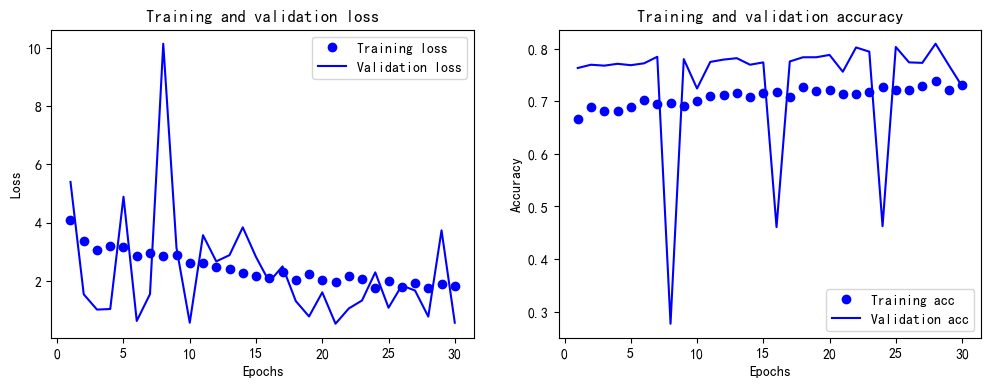

In [23]:
show_history(history) # 调用这个函数

In [24]:
result = dnn.evaluate(X_test, y_test) #评估测试集上的准确率
print('DNN的测试准确率为',"{0:.2f}%".format(result[1]*100))

45/45 [==============================] - 0s 2ms/step - loss: 0.5557 - acc: 0.7331
DNN的测试准确率为 73.31%


In [25]:
prediction = dnn.predict(X_test) #预测测试集的图片分类
print('第一个用户分类结果为:', np.argmax(prediction[0]))

45/45 [==============================] - 0s 966us/step
第一个用户分类结果为: 0


## 神经网络模型-归一化之后

In [26]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [27]:
# X_train = np.asarray(X_train).astype(np.float32)
# X_test = np.asarray(X_test).astype(np.float32)

In [28]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
scaler = MinMaxScaler() #创建归一化缩放器
X_train = scaler.fit_transform(X_train) #拟合并转换训练集数据
X_test = scaler.transform(X_test) #转换测试集数据

这段代码导入了 `MinMaxScaler` 类，它是 sklearn 库中用于数据预处理的一个功能模块。MinMaxScaler 将数据缩放到给定的最小值和最大值范围（默认区间为 [0, 1]）内，这样可以使数据更适合应用于神经网络训练。

创建 `MinMaxScaler` 的实例后，我们使用该实例对训练集数据 `X_train` 进行拟合（`fit`）和转换（`transform`）。拟合过程会计算训练集中特征的最小值和最大值，并在转换中应用它们以进行缩放。这样，原始训练集中的所有特征值都会在 0 到 1 之间。

完成训练集数据转换后，我们使用相同的缩放器实例对测试集数据 `X_test` 进行转换（但不拟合）。这样可以确保测试集数据的缩放方式与训练集数据相同。这一步非常重要，因为在训练过程中，模型学习了训练数据的分布特征。为了正确评估模型在新数据上的性能，我们需要以相同的方式预处理测试数据。

总之，在这段代码中，我们通过使特征值在 0 到 1 之间缩放，对训练集和测试集数据进行了预处理。这是一个常见的数据预处理步骤，有助于提高模型的训练效果。

Epoch 1/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4976 - acc: 0.7460 - val_loss: 0.4637 - val_acc: 0.7480
Epoch 2/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4778 - acc: 0.7650 - val_loss: 0.4424 - val_acc: 0.7888
Epoch 3/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4640 - acc: 0.7799 - val_loss: 0.4284 - val_acc: 0.7870
Epoch 4/30
71/71 [==============================] - 0s 3ms/step - loss: 0.4552 - acc: 0.7834 - val_loss: 0.4228 - val_acc: 0.7941
Epoch 5/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4493 - acc: 0.7846 - val_loss: 0.4185 - val_acc: 0.7959
Epoch 6/30
71/71 [==============================] - 0s 3ms/step - loss: 0.4447 - acc: 0.7821 - val_loss: 0.4162 - val_acc: 0.8012
Epoch 7/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4409 - acc: 0.7837 - val_loss: 0.4141 - val_acc: 0.7995
Epoch 8/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4371 - acc: 0.78

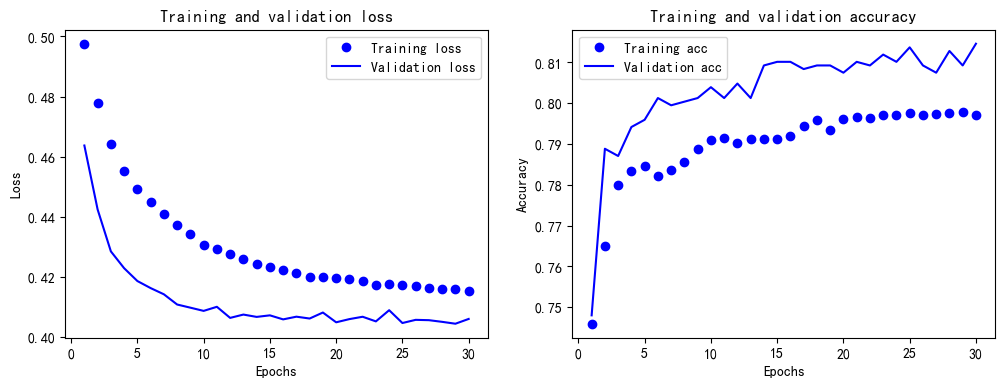

In [29]:
history = dnn.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #指定验证集,这里为了简化模型，直接用训练集数据
show_history(history) # 调用这个函数

In [30]:
result = dnn.evaluate(X_test, y_test) #评估测试集上的准确率
print('DNN（归一化之后）的测试准确率为',"{0:.2f}%".format(result[1]*100))

45/45 [==============================] - 0s 908us/step - loss: 0.4375 - acc: 0.7942
DNN（归一化之后）的测试准确率为 79.42%
